Figures for paper

In [2]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import matplotlib.ticker as ticker

# Fix Denisty Stream Function Y-axis

- Heatmap of density streamfunction anomaly
- Contours of period 1
- Y-axis scaled to volume per layer


    1. **Calculate volume per layer**:

       $
       V_i = dz_i \times UAREA
       $

    where $i$ denotes the layer index.

    2. **Aggregate densities along z**:

       - Convert the 2D density array into a 1D array by averaging along the z-axis.


    3. **Classify volumes by density**:
       - Define density classes (bins), e.g., $ \rho_1, \rho_2, \ldots, \rho_n $.
       - For each layer $ i $, find the density class $ \rho_k $ where $ \bar{\rho_i} $ belongs.
       - Sum the volumes of layers for each density class:

       $
       V_{\rho_k} = \sum_{i \in \text{class} \, k} V_i
       $



In [9]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0).squeeze()

replacement_value = 0
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
anom_smoc_ds = xr.open_dataset(smoc_file)

In [10]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')  

In [11]:
sigma_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc')

In [37]:
vol_av = (ds.TAREA * ds.dz).where(nan_mask).mean(dim=['nlon', 'nlat'])
sig_av = sigma_ds.SIGMA_2.mean(dim=['nlat', 'nlon', 'time'])

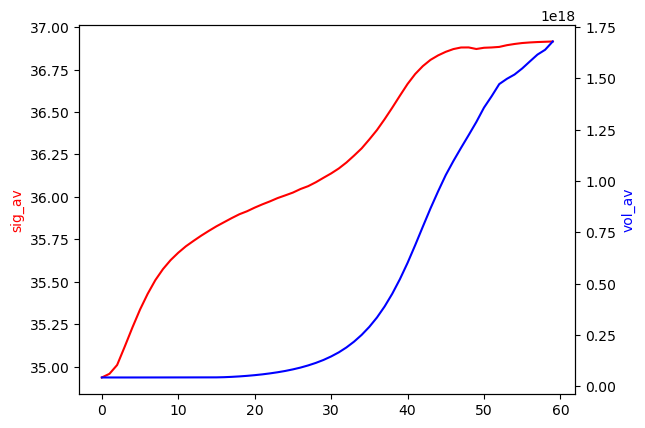

In [48]:
fig, ax1 = plt.subplots()

ax1.plot(sig_av, 'r')
ax1.set_ylabel('sig_av', color='r')
ax2 = ax1.twinx()
ax2.plot(vol_av, 'b')
ax2.set_ylabel('vol_av', color='b')
plt.show()

In [53]:
from scipy.interpolate import interp1d

volumes = vol_av.values  # Volume array as function of depths
densities = sig_av.values  # Density array as function of depths

In [55]:
# Ensure volumes and densities arrays are sorted by densities (required for interp1d if density is the independent variable)
# This sorting is crucial because interpolation requires the independent variable to be monotonic
sorted_indices = np.argsort(densities)
sorted_densities = densities[sorted_indices]
sorted_volumes = volumes[sorted_indices]

In [57]:
# Create an interpolation function based on sorted densities and corresponding volumes
volume_function_of_density = interp1d(sorted_densities, sorted_volumes, fill_value="extrapolate")

# Now using this function you can find volume for any density within the range (or extrapolated):
density_to_find_volume_for = np.array(sorted_densities)  # Using the sorted densities or any other in-range densities
calculated_volumes = volume_function_of_density(density_to_find_volume_for)

# This results in volumes calculated for each corresponding density
print(calculated_volumes)

[4.26287624e+16 4.26287624e+16 4.26287624e+16 4.25831048e+16
 4.26110003e+16 4.26400882e+16 4.26717910e+16 4.27087555e+16
 4.27556818e+16 4.28173868e+16 4.28657872e+16 4.28885368e+16
 4.29751773e+16 4.30259561e+16 4.30750801e+16 4.31279978e+16
 4.40149644e+16 4.56357540e+16 4.77938782e+16 5.05426860e+16
 5.38533046e+16 5.77678289e+16 6.25083850e+16 6.80010868e+16
 7.43818135e+16 8.20121635e+16 9.08397648e+16 1.01353835e+17
 1.13595877e+17 1.27881096e+17 1.44979594e+17 1.64831284e+17
 1.88739239e+17 2.17033670e+17 2.50179058e+17 2.89137219e+17
 3.34711237e+17 3.88388441e+17 4.50400172e+17 5.21297123e+17
 6.00397920e+17 6.87056886e+17 7.77034571e+17 8.65740155e+17
 9.49231904e+17 1.02847889e+18 1.09691283e+18 1.28678648e+18
 1.35667502e+18 1.16092981e+18 1.41213632e+18 1.22322340e+18
 1.47158524e+18 1.49718224e+18 1.51814100e+18 1.54761003e+18
 1.58168961e+18 1.61522171e+18 1.63857396e+18 1.67907312e+18]


# Recompute streamfunction with `sorted_densities`

In [4]:
vvel_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/VVELcomposite.nc'
sigma_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc'
dens_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.001.nc'

ds = xr.open_dataset(dens_file).isel(time=0, nlon=0).squeeze()
vvel_ds = xr.open_dataset(vvel_file)
sigma_ds = xr.open_dataset(sigma_file)

replacement_value = 0
ds['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds['ULAT']), np.isinf(ds['ULAT']) | np.ma.getmask(ds['ULAT'])),
    replacement_value,
    ds['ULAT']
)

In [59]:
def density_MOC(ds_vvel, ds_sigma, ds_parameters):
    sigma_level = sorted_densities
    min_lat = 250
    max_lat = 365
    smoc = []
    for time_idx in range(len(ds_vvel.time)):
        ds_vvel_time_step = ds_vvel.isel(time=time_idx)
        ds_sigma_time_step = ds_sigma.isel(time=time_idx)
        overturning = np.zeros([len(sigma_level), (max_lat - min_lat)])
        for j in range(min_lat, max_lat):
            sigma_transport = np.zeros(len(sigma_level))
            v_transport = (ds_vvel_time_step.VVEL.isel(nlat=j) * ds_parameters.dz.isel(nlat=j) * ds_parameters.DXU.isel(nlat=j)).values
            sigma_crossection = ds_sigma_time_step.SIGMA_2.isel(nlat=j).values
            for i in range(len(sigma_level) - 1):
                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i + 1]))
                sigma_transport[i] = np.nansum(v_transport[ind])
            overturning[:, j - min_lat] = np.cumsum(sigma_transport)[::-1]
            overturning[:, j - min_lat] = overturning[:, j - min_lat][::-1]
        overturning_ds = xr.Dataset({'densMOC': (['sigma', 'nlat'], overturning)})
        overturning_ds['densMOC'] = overturning_ds.densMOC*1e-12
        overturning_ds['sigma'] = sigma_level
        overturning_ds['nlat'] = ds_parameters.nlat.isel(nlat=slice(min_lat, max_lat))
        smoc.append(overturning_ds)
    smoc_ds = xr.concat(smoc, dim='time')
    return smoc_ds

In [60]:
smoc_ds = density_MOC(vvel_ds, sigma_ds, ds)
print('sMOC composite computed')
smoc_ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite-sorted.nc')

sMOC composite computed


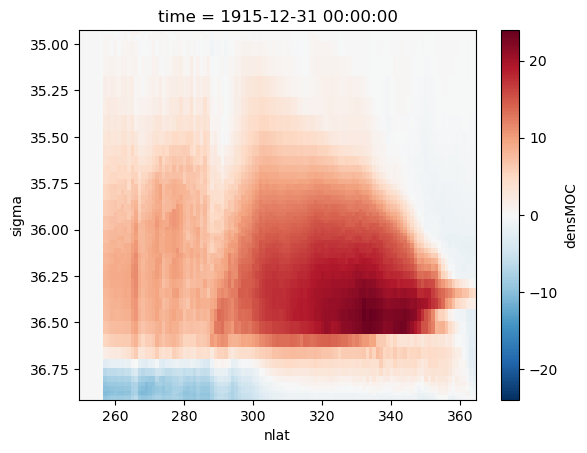

In [63]:
smoc_ds.densMOC.isel(time=0).plot(yincrease=False)

# Rescale y axis

In [65]:
weighted_densities = sorted_densities * calculated_volumes

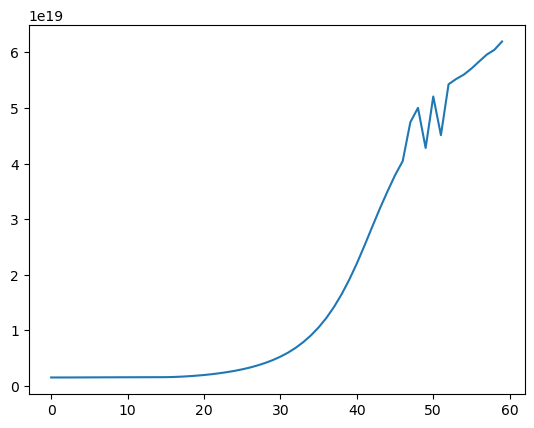

In [71]:
plt.plot(weighted_densities)

/tmp/ipykernel_31922/3793194308.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), cmap=cmo.balance)


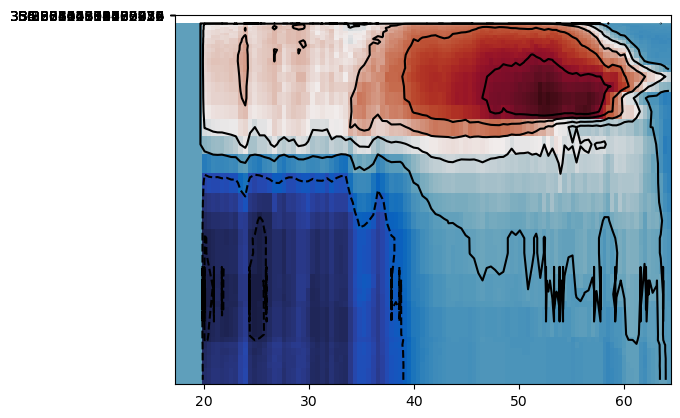

In [117]:
plt.pcolormesh(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), cmap=cmo.balance)
#cbar = plt.colorbar(pc)
plt.contour(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), colors='k')
plt.yticks(np.arange(len(sorted_densities))[::5], sorted_densities[::5])
plt.gca().invert_yaxis()
plt.show()

In [107]:
sorted_densities

array([34.93614813, 34.9578122 , 35.00964641, 35.1183501 , 35.2305248 ,
       35.3365047 , 35.42915185, 35.50959735, 35.57460779, 35.62762557,
       35.67111872, 35.70908475, 35.74091352, 35.77153398, 35.79984782,
       35.8268007 , 35.85105131, 35.8752147 , 35.89779526, 35.9154073 ,
       35.93675417, 35.95600783, 35.97367325, 35.99304331, 36.00893165,
       36.02535853, 36.04645767, 36.06327999, 36.08619115, 36.11248339,
       36.13816436, 36.16728558, 36.20238324, 36.24309049, 36.28594763,
       36.33856534, 36.39389841, 36.45772171, 36.52552381, 36.59612625,
       36.66504614, 36.7238107 , 36.77042751, 36.8070972 , 36.83360747,
       36.85462751, 36.87082049, 36.87123488, 36.87847967, 36.88012872,
       36.88032291, 36.88046028, 36.8835508 , 36.89367036, 36.90081019,
       36.90642509, 36.90981405, 36.91219296, 36.9138063 , 36.91554088])

/tmp/ipykernel_31922/517063577.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), cmap=cmo.balance)


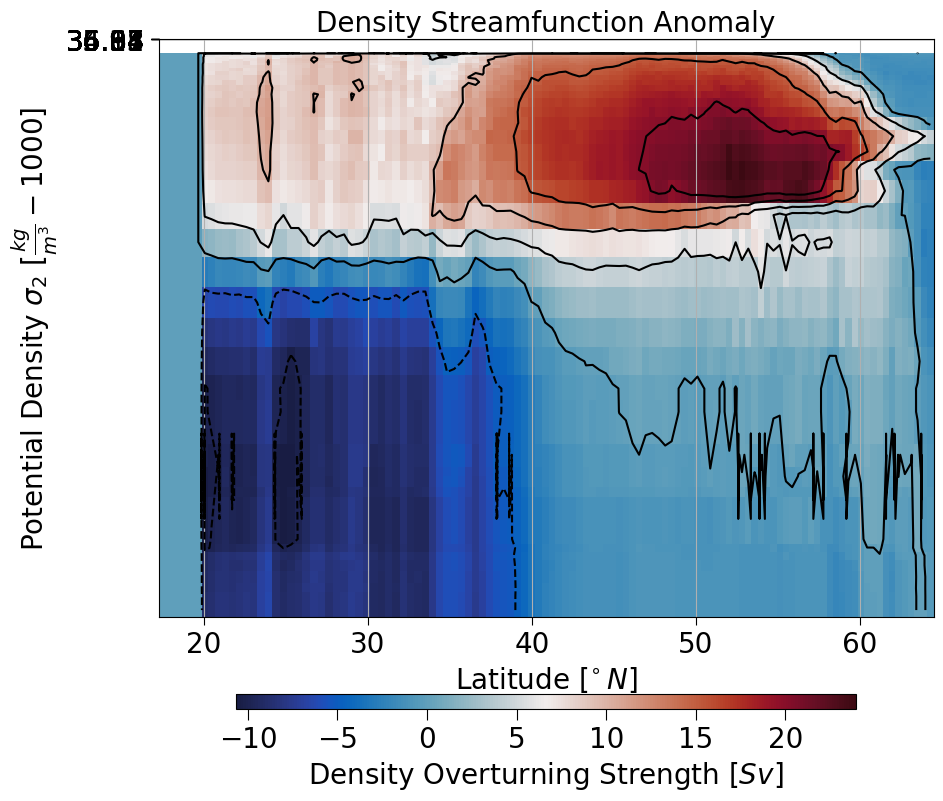

In [114]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), cmap=cmo.balance)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds.TLAT.isel(nlat=(slice(250,365))), weighted_densities, smoc_ds.densMOC.isel(time=0), colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sorted_densities))[::5], np.round(sorted_densities, 2)[::5])

#ax.set_xlim([21, 64])  
#ax.set_ylim([34, 36.9])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

plt.show()

# **Check one latitude timeseries function**

In [1]:
import os
import re
import xarray as xr
import pop_tools  
import gsw
import numpy as np
import cftime
import pandas as pd

In [2]:
def density_overturning(vvel_dataset, density_dataset, latitude_index):
    density_bins = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 
                   31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 
                   35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 36.4, 36.42, 
                   36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 
                   36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 36.78, 36.8, 36.82, 
                   36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 37.14, 
                   37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
    max_overturning_series = []

    for time_step in range(len(vvel_dataset.time)):
        
        # compute meridional flow rate for the specified latitude
        cell_thickness = vvel_dataset['dz'].isel(time=time_step, nlat=latitude_index)
        cell_width = vvel_dataset['DXU'].isel(time=time_step, nlat=latitude_index)
        velocity = vvel_dataset['VVEL'].isel(time=time_step, nlat=latitude_index)
        flow_rate = velocity * cell_thickness * cell_width

        # compute meridional flow rate and for each density bin and integrate zonally
        density_at_time = density_dataset.isel(time=time_step)
        flow_rate_by_density = np.zeros(len(density_bins))
        for bin_index in range(len(density_bins) - 1):
            in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
            flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

        # compute density overturning, reverse to integrate from high to low density
        density_overturning = np.cumsum(flow_rate_by_density)[::-1]
        max_overturning = np.max(density_overturning)
        max_overturning_series.append(max_overturning)
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": vvel_dataset['time']})
    return max_overturning_dataarray  * 1e-12

In [3]:
def extract_member_id(filename):
    match = re.search(r'vvel_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def calculate_sigma2(temp_ds, salt_ds, nlat=345):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'].isel(nlat=nlat), temp_ds['TEMP'].isel(nlat=nlat))
    sigma2_at_latitude = gsw.density.sigma2(salt_ds['SALT'].isel(nlat=nlat), CT)
    return sigma2_at_latitude

In [4]:
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt'
file='vvel_1301.019.nc'
member_id = extract_member_id(file)
vvel_path = os.path.join(vvel_dir, file)
temp_path = os.path.join(temp_dir, f'temp_{member_id}.nc')
salt_path = os.path.join(salt_dir, f'salt_{member_id}.nc')

In [5]:
# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [260.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}
    ]
}
maskSPG = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Subpolar Gyre')
maskSPG = maskSPG.sum('region')
maskSPG = maskSPG.roll(nlon=-100)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
temp_ds = xr.open_dataset(temp_path).isel(time=slice(0,35)).resample(time='AS').mean().where(maskSPG)
temp_ds = standardise_time(temp_ds)
salt_ds = xr.open_dataset(salt_path).isel(time=slice(0,35)).resample(time='AS').mean().where(maskSPG)
salt_ds = standardise_time(salt_ds)

In [8]:
sel_nlat = 345
vvel_ds = xr.open_dataset(vvel_path).isel(time=slice(0,35)).resample(time='AS').mean().where(maskSPG)
vvel_ds = standardise_time(vvel_ds)
max_overturning_series = density_overturning(vvel_ds, sigma_ds, sel_nlat)

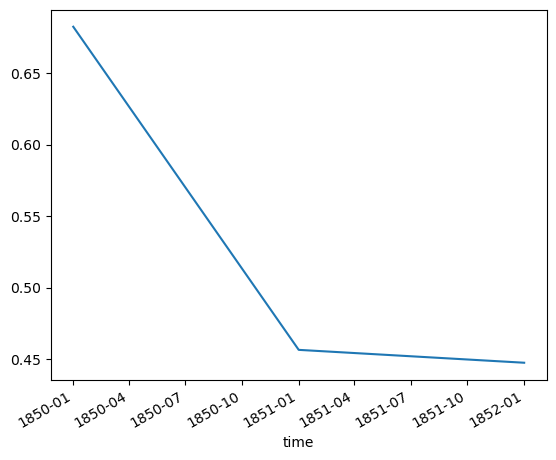

In [10]:
max_overturning_series.plot()

In [1]:
#!/usr/bin/env python3
# inagler 25/06/24

import os
import re
import gc

import numpy as np
import pandas as pd
import xarray as xr

import cftime
import pop_tools  
import gsw

# choose latitude
sel_nlat = 345

vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt'

output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries'
missing_files_report = os.path.join(output_dir, 'missing_files.txt')

# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [260.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}
    ]
}
maskSPG = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Subpolar Gyre')
maskSPG = maskSPG.sum('region')
maskSPG = maskSPG.roll(nlon=-100)

def extract_member_id(filename):
    match = re.search(r'vvel_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def calculate_sigma2(temp_ds, salt_ds, nlat=345):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'].isel(nlat=nlat), temp_ds['TEMP'].isel(nlat=nlat))
    sigma2_at_latitude = gsw.density.sigma2(salt_ds['SALT'].isel(nlat=nlat), CT)
    return sigma2_at_latitude

def density_overturning(vvel_dataset, density_dataset, latitude_index):
    density_bins = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 
                   31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 
                   35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 36.4, 36.42, 
                   36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 
                   36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 36.78, 36.8, 36.82, 
                   36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 37.14, 
                   37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
    max_overturning_series = []

    for time_step in range(len(vvel_dataset.time)):
        
        # compute meridional flow rate for the specified latitude
        cell_thickness = vvel_dataset['dz'].isel(time=time_step, nlat=latitude_index)
        cell_width = vvel_dataset['DXU'].isel(time=time_step, nlat=latitude_index)
        velocity = vvel_dataset['VVEL'].isel(time=time_step, nlat=latitude_index)
        flow_rate = velocity * cell_thickness * cell_width

        # compute meridional flow rate and for each density bin and integrate zonally
        density_at_time = density_dataset.isel(time=time_step)
        flow_rate_by_density = np.zeros(len(density_bins))
        for bin_index in range(len(density_bins) - 1):
            in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
            flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

        # compute density overturning, reverse to integrate from high to low density
        density_overturning = np.cumsum(flow_rate_by_density)[::-1]
        max_overturning = np.max(density_overturning)
        max_overturning_series.append(max_overturning)
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": vvel_dataset['time']})
    return max_overturning_dataarray  * 1e-12



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def load_and_process_dataset(file_path, mask):
    ds = xr.open_dataset(file_path, decode_times=False)
    ds = standardise_time(ds)
    try:
        processed_dataset = ds.isel(time=slice(0,35)).where(mask).resample(time='AS').mean()
    except RuntimeError as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    return processed_dataset

def handle_deprecated_data(ds, mask):
    total_time_steps = ds.dims['time']
    last_valid_data = None
    for t in range(total_time_steps):
        try:
            current_data = ds.isel(time=t).load()
            last_valid_data = current_data
        except RuntimeError as e:
            print(f"Error at timestep {t}: {str(e)}")
            if last_valid_data is not None:
                current_data = last_valid_data
            else:
                raise ValueError(f"No valid data at timestep {t}")
        if t == 0:
            combined_data = current_data
        else:
            combined_data = xr.concat([combined_data, current_data], dim='time')
    combined_data['time'] = np.arange(total_time_steps)
    result_dataset = combined_data.where(mask, drop=True).resample(time='AS').mean()
    return result_dataset

In [4]:
total_members = len(os.listdir(temp_dir))
processed_count = 0

for file in os.listdir(vvel_dir):
    member_id = extract_member_id(file)
    vvel_path = os.path.join(vvel_dir, file)
    temp_path = os.path.join(temp_dir, f'temp_{member_id}.nc')
    salt_path = os.path.join(salt_dir, f'salt_{member_id}.nc')
 
    temp_ds = load_and_process_dataset(temp_path, maskSPG)
    salt_ds = load_and_process_dataset(salt_path, maskSPG)
    sigma_ds = calculate_sigma2(temp_ds, salt_ds)
    vvel_ds = load_and_process_dataset(vvel_path, maskSPG)
    
    max_overturning_series = density_overturning(vvel_ds, sigma_ds, sel_nlat)
    max_overturning_series.to_netcdf(os.path.join(output_dir, f'annual_smoc55_member_{member_id}.nc'))

    processed_count += 1
    print(f'{member_id} saved')

    temp_ds.close()
    salt_ds.close()
    sigma_ds.close()
    vvel_ds.close()
    max_overturning_series.close()

    del temp_ds, salt_ds, sigma_ds, vvel_ds, max_overturning_series
    gc.collect()

    print(f'{member_id} saved')
    
    break
    
print('')
print('computation complete')
print('')

1001.001 saved
1001.001 saved

computation complete



In [3]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
file = 'annual_smoc55_member_1001.001.nc'

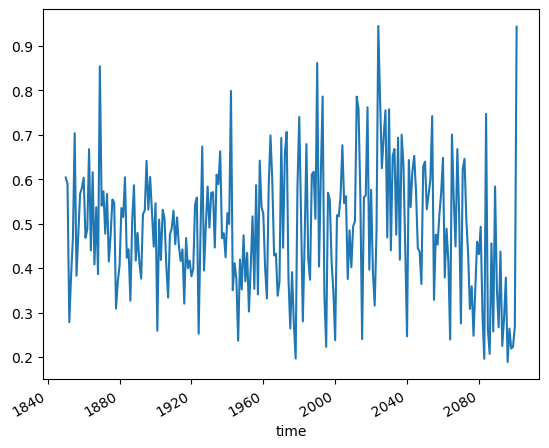

In [5]:
xr.open_dataarray(path+file).plot()